## QBO Analysis of FMU DATA

In [1]:
from extract_fub_data import FUBDataFile
import numpy as np 
with FUBDataFile("../data/qbo.dat") as f:
    data = f.to_numpy()

data = data[~np.isnan(data[:,-1])]


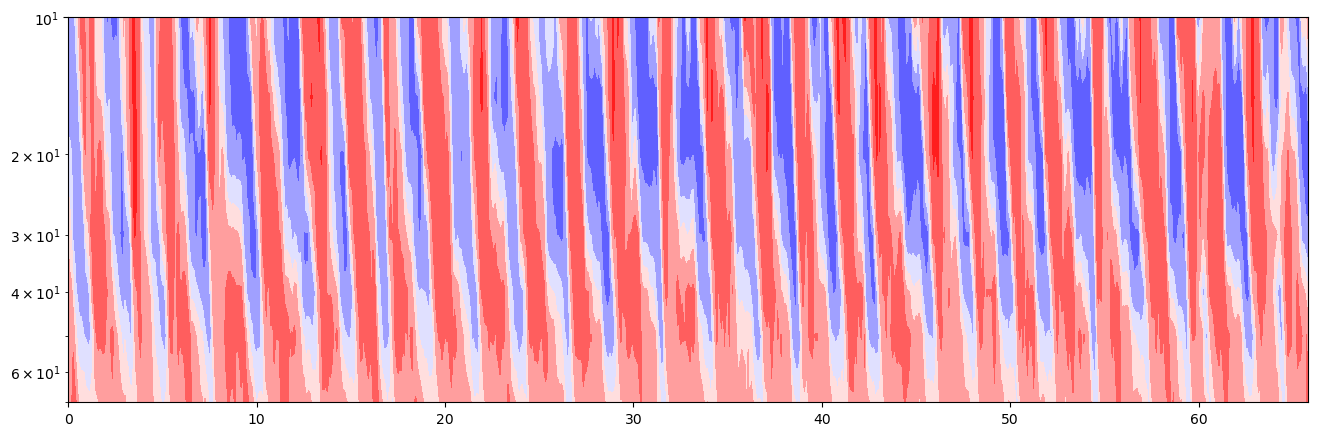

In [2]:
import matplotlib.pyplot as plt

pressures = np.array([70,50,40,30,20,15,10])

pv,tv = np.meshgrid(pressures,np.arange(data.shape[0])/12,)
fig,ax = plt.subplots(figsize=(16,5))
ax.contourf(tv,pv,data,cmap='bwr')
ax.invert_yaxis()
ax.set_yscale("log")

In [3]:
toplevel = data[:,-1]

In [62]:
N=5
smoothed = np.convolve(toplevel,np.ones(N),mode='same')/N

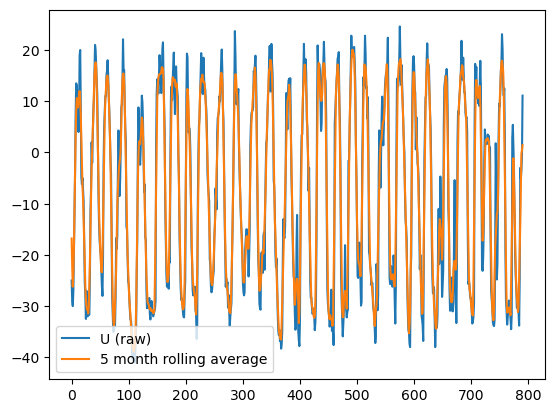

In [63]:
fig,ax = plt.subplots()
ax.plot(toplevel,label="U (raw)")
ax.plot(smoothed,label=f"{N} month rolling average")
ax.legend()

use 3rd order (cubic) interpolated univariate spline and find roots to determine inversion points

In [64]:
from scipy.interpolate import InterpolatedUnivariateSpline
interp = InterpolatedUnivariateSpline(np.arange(len(smoothed)),smoothed,k=3)

In [65]:
roots = interp.roots()

In [66]:
periods = roots[2::2] - roots[:-2:2]

In [67]:
np.mean(periods)

27.915249015787193

In [68]:
np.std(periods)

4.538404428603899

### Fourier transform based method

In [31]:
from scipy.fft import fft,fftfreq
smoothed_fft = fft(smoothed - np.mean(smoothed))
freq = fftfreq(len(smoothed))
imax = np.argmax(np.abs(smoothed_fft))
main_freq = freq[imax]
period = 1/main_freq
period 


28.25

Use transition bins to estimate amplitude for each wave period

In [32]:
transitions = np.round(roots).astype(int)
amplitudes = []
for (start,stop) in zip(transitions[::2],transitions[2::2]):
    max = np.max(toplevel[start:stop])
    min = np.min(toplevel[start:stop])
    amplitudes.append((max-min)/2)
amplitudes = np.array(amplitudes)

In [33]:
np.mean(amplitudes)

26.587500000000002

In [34]:
np.std(amplitudes)

2.953799762291663

### covariance between amplitude and periods

In [22]:
np.cov(np.vstack([amplitudes,periods]))

array([[ 7.39804233,  6.20228864],
       [ 6.20228864, 21.3635842 ]])